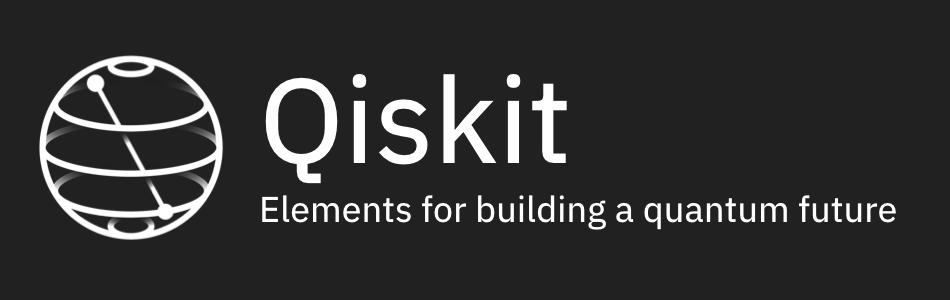

# Obtaining information about your `backend`

#### _Note: All the attributes of the backend are described in detail in the [Qiskit Backend Specifications](https://arxiv.org/pdf/1809.03452.pdf). This page reviews a subset of the spec._

Programming a quantum computer at the microwave pulse level requires more information about the device than is required at the circuit level. A quantum circuit is built for an abstract quantum computer -- it will yield the same quantum state on any quantum computer (except for varying performance levels). A pulse schedule, on the other hand, is so specific to the device, that running one program on two different backends is not expected to have the same result, even on perfectly noiseless systems.

As a basic example, imagine a drive pulse `q0_X180` calibrated on qubit 0 to enact an $X180$ pulse, which flips the state of qubit 0. If we use the samples from that pulse on qubit 1 on the same device, or qubit 0 on another device, we do not know what the resulting state will be -- but we can be pretty sure it won't be an $X180$ operation. The qubits are each unique, with various drive coupling strengths. If we have specified a frequency for the drive pulse, it's very probable that pulse would have little effect on another qubit, which has its own resonant frequency.

With that, we have motivated why information from the backend may be very useful at times for building Pulse schedules. The information included in a `backend` is broken into three main parts:

 - **Configuration**: static backend features
 - **Properties**: measured and reported backend characteristics
 - **Defaults**: default settings for the OpenPulse-enabled backend
 
which are each covered in the following sections. While all three of these contain interesting data for Pulse users, the defaults are _only_ provided for backends enabled with OpenPulse.

The first thing you'll need to do is grab a backend to inspect. Here we use a mocked backend that contains a snapshot of data from the real OpenPulse-enabled backend.

In [1]:
from qiskit.test.mock import FakeAlmaden

backend = FakeAlmaden()

## Configuration

The configuration is where you'll find data about the static setup of the device, such as its name, version, the number of qubits, and the types of features it supports.

Let's build a description of our backend using information from the `backend`'s config.

In [2]:
config = backend.configuration()

# Basic Features
print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates))

This backend is called fake_almaden, and is on version 1.2.4. It has 20 qubits. It supports OpenPulse programs. The basis gates supported on this device are ['u1', 'u2', 'u3', 'cx', 'id'].


Neat! All of the above configuration is available for any backend, whether enabled with OpenPulse or not, although it is not an exhaustive list. There are additional attributes available on Pulse backends. Let's go into a bit more detail with those.

The **timescale**, `dt`, is backend dependent. Think of this as the inverse sampling rate of the control rack's arbitrary waveform generators. Each sample point and duration in a Pulse `Schedule` is given in units of this timescale.

In [3]:
config.dt  # units of seconds

/Users/lauren@ibm.com/code/qiskit-terra/qiskit/providers/models/backendconfiguration.py:355: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


2.222222222222222e-19

The configuration also provides information that is useful for building measurements. Pulse supports three measurement levels: `0: RAW`, `1: KERNELED`, and `2: DISCRIMINATED`. The `meas_levels` attribute tells us which of those are supported by this backend. To learn how to execute programs with these different levels, see this page -- COMING SOON.

In [4]:
config.meas_levels

[1, 2]

For backends which support measurement level 0, the sampling rate of the control rack's analog-to-digital converters (ADCs) also becomes relevant. The configuration also has this info, where `dtm` is the time per sample returned:

In [5]:
config.dtm

2.222222222222222e-19

The measurement map, explained in detail on [this page COMING SOON], is also found here.

In [6]:
config.meas_map

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]

The configuration also supplies convenient methods for getting channels for your schedule programs. For instance:

In [7]:
config.drive(0)

DriveChannel(0)

In [8]:
config.measure(0)

MeasureChannel(0)

In [9]:
config.acquire(0)

AcquireChannel(0)

It is a matter of style and personal preference whether you use `config.drive(0)` or `DriveChannel(0)`.

## Properties

The `backend` properties contain data that was measured and optionally reported by the provider. Let's see what kind of information is reported for qubit 0.

In [10]:
props = backend.properties()

In [11]:
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    # Conversion factors from standard SI units
    us = 1e6
    ns = 1e9
    GHz = 1e-9

    print("Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('u2', qubit),
              properties.gate_length('u2', qubit) * ns,
              properties.frequency(qubit) * GHz))

describe_qubit(0, props)

Qubit 0 has a 
  - T1 time of 113.3795751321217 microseconds
  - T2 time of 150.2847720544259 microseconds
  - U2 gate error of 0.0005295247303964942
  - U2 gate duration of 35.555555555555564 nanoseconds
  - resonant frequency of 4.8572819835984875 GHz


Properties are not guaranteed to be reported, but backends without Pulse access typically also provide this data.

## Defaults

Unlike the other two sections, `PulseDefaults` are only available for Pulse-enabled backends. It contains the default program settings run on the device.

In [12]:
defaults = backend.defaults()

### Drive frequencies

Defaults contains the default frequency settings for the drive and measurement signal channels:

In [13]:
q0_freq = defaults.qubit_freq_est[0]  # Hz
q0_meas_freq = defaults.meas_freq_est[0]  # Hz

GHz = 1e-9
print("DriveChannel(0) defaults to a modulation frequency of {} GHz.".format(q0_freq * GHz))
print("MeasureChannel(0) defaults to a modulation frequency of {} GHz.".format(q0_meas_freq * GHz))

DriveChannel(0) defaults to a modulation frequency of 4.857219891603379 GHz.
MeasureChannel(0) defaults to a modulation frequency of 7.264856891000001 GHz.


/Users/lauren@ibm.com/code/qiskit-terra/qiskit/providers/models/pulsedefaults.py:155: UserWarning: `qubit_freq_est` and `meas_freq_est` now have units of Hertz(Hz) rather than gigahertz(GHz).
  warnings.warn('`qubit_freq_est` and `meas_freq_est` now have units of '


### Pulse Schedule definitions for QuantumCircuit instructions

Finally, one of the most important aspects of the `backend` for `Schedule` building is the `InstructionScheduleMap`. This is a basic mapping from a circuit operation's name and qubit to the default pulse-level implementation of that instruction. 

In [14]:
inst_map = defaults.instruction_schedule_map
print(inst_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q1: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q2: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q3: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q4: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q5: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q6: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q7: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q8: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q9: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q10: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q11: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q12: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q13: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q14: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q15: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q16: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q17: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q18: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
  q19: {'MEAS', 'x', 'u2', 'u3', 'id', 'u1'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2):

Rather than build a measurement schedule from scratch, let's see what was calibrated by the backend to measure the qubits on this device:

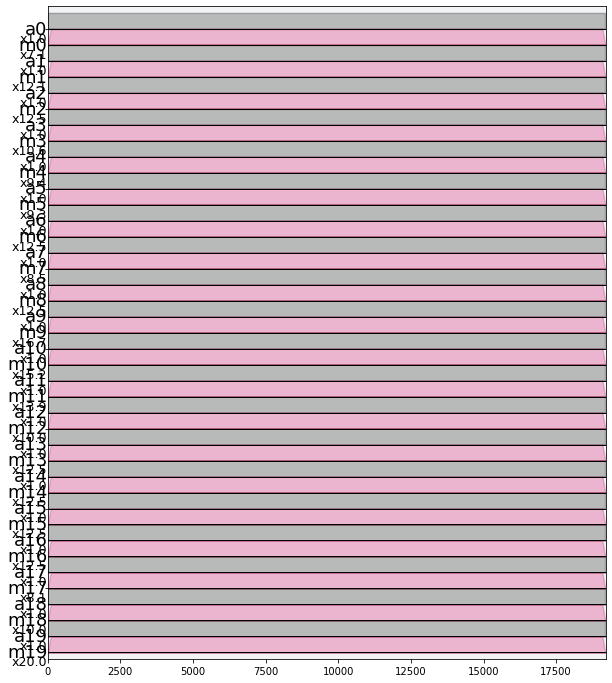

In [15]:
measure_schedule = inst_map.get('measure', [q for q in range(config.n_qubits)])
measure_schedule.draw()

This can easily be appended to your own Pulse `Schedule` (`sched += inst_map.get('measure', <qubits>) << sched.duration`)!

Likewise, each qubit will have a `Schedule` defined for each basis gate, and they can be appended directly to any `Schedule` you build.

In [16]:
# You can use `has` to see if an operation is defined. Ex: Does qubit 3 have an x gate defined?
inst_map.has('x', 3)

True

In [17]:
# Some circuit operations take parameters. U1 takes a rotation angle:
inst_map.get('u1', 0, P0=3.1415)

Schedule((0, FrameChangeInstruction(FrameChange(phase=-3.142, name="fc328"), DriveChannel(0))), (0, FrameChangeInstruction(FrameChange(phase=-3.142, name="fc329"), ControlChannel(1))), name="u1")

While building your schedule, you can also use `inst_map.add(name, qubits, schedule)` to store useful `Schedule`s that you've made yourself. 

In [18]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright